<a href="https://colab.research.google.com/github/Userfound404/GSoC-QMLHEP-Tasks/blob/main/QMLHEP_GSoC'24_Task_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 4

You will explore how best to apply a quantum generative adversarial network (QGAN) to solve a High Energy Data analysis issue, more specifically, separating the signal events from the background events. You should use the Google Cirq and Tensorflow Quantum (TFQ) libraries for this task.

A set of input samples (simulated with Delphes) is provided in NumPy NPZ format [Download Input]. In the input file, there are only 100 samples for training and 100 samples for testing so it won’t take much computing resources to accomplish this
task. The signal events are labeled with 1 while the background events are labeled with 0.

Be sure to show that you understand how to fine tune your machine learning model to improve the performance. The performance can be evaluated with classification accuracy or Area Under ROC Curve (AUC).


In [ ]:
!pip3 install --upgrade pip
!pip3 install tensorflow==2.7.0

In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip3 install -U tensorflow-quantum

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq

# for visualization
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

import sympy
import numpy as np

In [ ]:
%cd 'drive/MyDrive/Projects/GSOC'

/content/drive/MyDrive/Projects/GSOC


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Understanding the dataset
The dataset contains 100 samples each for testing and training. The file is a numpy array file having 5 features.

**Labels are binary**.

0 ---> background events

1 ---> signal events

\

In [ ]:
# Load data from npz file
with np.load('./QIS_EXAM_200Events.npz', allow_pickle=True) as data:
    # Extract training and test inputs from dictionary objects in the npz file
    x_train = data["training_input"].item()
    x_test = data["test_input"].item()

# Split the training and test inputs by class
x_train_0 = x_train['0']
x_train_1 = x_train['1']
x_test_0 = x_test['0']
x_test_1 = x_test['1']

# Concatenate the training and test inputs
x_train = np.concatenate((x_train_0, x_train_1), axis=0)
x_test = np.concatenate((x_test_0, x_test_1), axis=0)

# Create corresponding binary labels for the training and test inputs
y_train = np.zeros((len(x_train),))
y_train[len(x_train_0):] = 1
y_test = np.zeros((len(x_test),))
y_test[len(x_test_0):] = 1

# the shapes of the inputs and labels
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(100, 5) (100,)
(100, 5) (100,)


## Understanding QGAN's

**GAN's or Generative Adversarial Networks** are popular among new data generation.

they consists of a discriminator and a generator, two neural networks that work simulatanously. The generator produces samples that are meant to resemble the training set's data using random noise as input. The discriminator attempts to differentiate between real and generated samples that it receives as input.

Training is like playing a game where the generator gets rewarded if it can fool the discriminator but if the discriminator can find out that it's a fake output then it gets rewarded and the generator gets a penalty.

Just after a few iterations the generator becomes capable of generating new data that resembles the original.

By implementing the generator and discriminator functions using quantum circuits, QGANs extend this idea to quantum computing. These circuits can create or categorise quantum states by using quantum entanglement and superposition, which may be advantageous in some situations compared to classical machine learning models.




#### Classical Data ---> Quantum Data

Angle encoding can be used to transform the real or classical data into their quantum state. By treating the value of each sample's features as angles for RY gates that act on |00..00> qubits, each sample is converted into a quantum state.

We require 5 qubits with a RY gate on every qubit to encode this data because there are a total of 5 features for each sample.


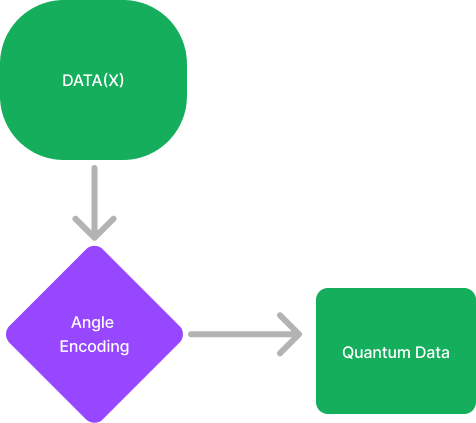

**We have to discriminate signal events from background events, so we must create a discriminator that can classify well**



A parametrized quantum circuit (PQC) will be used as the generator in order to create synthetic data using a quantum generative adversarial network (QGAN) that resembles real data. A PQC will be used as the discriminator, which has two tasks: classify the data into the correct label and determine whether the data is real or fake, in order to assess the quality of the generated data.

For the first task we convert the data through angle encoding and then use the discriminator to find out the event.

The architecture is defined below:

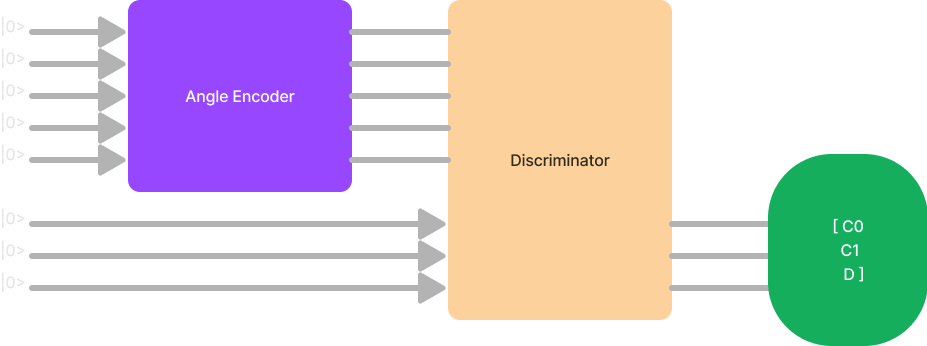



fig : Quantum Discriminator schematic when connected to real quantum data.

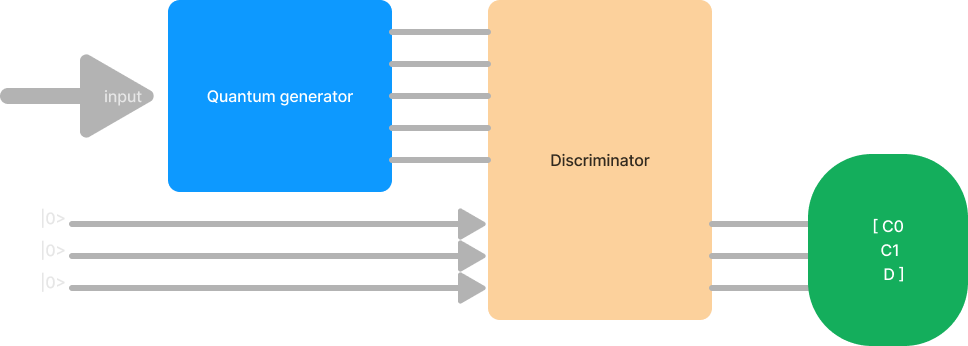

fig : Quantum Discriminator schematic when connected to fake quantum data (quantum generator).

There are 8 qubits in the quantum discriminator (qdisc). The quantum data circuit will be connected to qdisc via the first five qubits, which are the data qubits. The final three qubits are considered to be the output qubits, with the final output being the real/fake prediction [D] and the first two outputs being considered to be the class predictions [C0, C1] ([1, -1] for label 0 and [-1, 1] for label 1).

 1 for real and -1 for fake.

Each data qubit is given a Hadamard gate, followed by a number of one-qubit unitaries and CNOT gates that entangle nearby qubits. For multiple layers, one can repeat the one-qubit unitaries and CNOT gates. At the end of the circuit, each output qubit receives a final one-qubit unitary gate. Pauli-Z gates are used to measure each output qubit.

note that discriminator is trained on both on quantum fake data and quantum real data.
while the real data is from angle encoder, quantum data is from the generator.


The loss function is for the discriminator is :    
1. Generated data:
  $$
  Loss ({x}_{\text {real}}^{j}) + Loss ({x}_{\text {fake}}^{i})
  $$

  Which can be defined as

  $$
  L_{D}=-\frac{1}{m_{\text{fake}} + m_{\text{real}}} \left( \sum_{i=1}^{m_{\text{fake}}}\log \left(1-D\left(\boldsymbol{x}_{\text {fake}}^{i}\right)\right)+\sum_{i=j}^{m_{\text{real}}}\log D\left(\boldsymbol{x}_{\text {real}}^{j}\right)\right)
  $$

  where $m_{\text{fake}}$ and $m_{\text{real}}$ are the total number of fake and real data in the batch respectively, $D$ is prediction from the made by the Discriminator, either 1 or 0.

  It is calculated as the negative average of the sum of the logarithms of the discriminator's predictions for the fake and real data.

2. Classfied data:
  $$
L_{C}= H(y_{true}, C(\boldsymbol{x}_{\text {real}}))
$$
where $H$ is the categorical crossentropy loss function, $y_{true}$ is the true label set of all the samples in the batch, $C$ is the class prediction from the qdisc.

  the loss for the real data is computed as the logarithm of the discriminator's prediction for each real data point, and these losses are summed over all real data points in the batch.

**The final Loss Function** will be the partial sum of both $L_{C}$ and $L_{D}$

$$
L = (1-C_{weight})L_{D} + C_{weight}L_{C}
$$

$C_{weight}$ is the hyperparameter that decides which task is to prioritized, higher $C_{weight}$ means that classification is more important than fake/real prediction. and lower $C_{weight}$ will prioritize the generator's output.


Since the classes are defined as [0,1] we convert our discriminator's output also as [0,1] from [-1,1], where 1 is real and 0 is fake.

These loss functions are also inspired from the reference [1].


### Quantum Generator(QGen)

The quantum generator is constructed using 10 qubits. since the input data is represented using angle encoding, which requires only 5 qubits, the first 5 qubits of the qgen are reserved for encoding the input data.

The remaining 5 qubits in the qgen serve as the generator's workspace rather than being used to encode the input data. This indicates that they can be used as part of the generator's operation to carry out intermediate calculations or transformations on the input data.

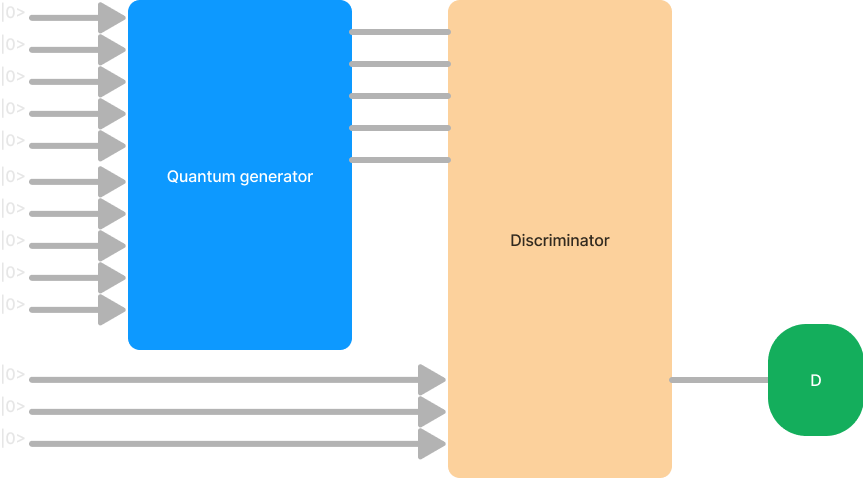

fig 3: Diagram of the quantum generator with the discriminator attached. Keep in mind that during generator training, we only require the [$D$] output from the discriminator.

The Loss function for the Generator depends on the output $[D]$ and it can be defined as:

$$
L_{G}=-\frac{1}{m} \sum_{i=1}^{m} \log \left(D\left(\boldsymbol{x}_{\text {fake }}^{i}\right)\right)
$$

where $m$ is the total number of fake data in the batch, $D$ is the fake/real prediction from the qdisc.

### Implementation

In [ ]:
# Check class balances
print("Class 0:", (y_train == 0).sum(), "Class 1:", (y_train == 1).sum())
print("Class 0:", (y_test == 0).sum(), "Class 1:", (y_test == 1).sum())

Class 0: 50 Class 1: 50
Class 0: 50 Class 1: 50


The classes are balanced.


In [ ]:
# convert label format from 1/0 to 1/-1
y_train = tf.keras.utils.to_categorical(y_train)*2-1
y_test = tf.keras.utils.to_categorical(y_test)*2-1

y_train = np.concatenate((y_train, np.ones((len(y_train), 1))), axis=1)
y_test = np.concatenate((y_test, np.ones((len(y_test), 1))), axis=1)

print(y_train.shape, y_test.shape)

(100, 3) (100, 3)


In [ ]:
#Angle Encoding
def generate_data(X, qubits):
    """Generate quantum data from the dataset with angle encoding."""
    quantum_data = []
    # iterate through data samples
    for sample in X:
        circuit = cirq.Circuit()
        # iterate through sample's features
        for bit in range(len(sample)):
            circuit.append(cirq.ry(sample[bit])(qubits[bit]))

        quantum_data.append(circuit)

    return quantum_data

In [ ]:
# converting the classical data set
# using 5 qubits
qubits = cirq.GridQubit.rect(1, 5)
# converting data first to tensors, for tensorflow as it can't read numpy
train_quantum_data = tfq.convert_to_tensor(generate_data(x_train, qubits))
test_quantum_data = tfq.convert_to_tensor(generate_data(x_test, qubits))

In [ ]:
# label -1
print(tfq.from_tensor(train_quantum_data)[y_train[:, 0]==-1][0])

(0, 0): ───Y^-0.135───

(0, 1): ───Y^0.282────

(0, 2): ───Y^-0.298───

(0, 3): ───Y^-0.207───

(0, 4): ───Y^(-1/8)───


In [ ]:
# label 1
print(tfq.from_tensor(train_quantum_data)[y_train[:, 0]==1][0])

(0, 0): ───Y^-0.137────

(0, 1): ───Y^0.276─────

(0, 2): ───Y^-0.295────

(0, 3): ───Y^-0.295────

(0, 4): ───Y^(-2/11)───


Let's define the Quantum generator :
The function takes three arguments: qubits (a list of qubits that the circuit will act on), symbols (a list of parameters that will be used to create the circuit), and layer (an optional argument that specifies how many layers of gates the circuit will have, with a default value of 1).

In [ ]:
def one_qubit_unitary(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])


def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    circuit += one_qubit_unitary(bits[0], symbols[0:3])
    circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[6]]
    circuit += [cirq.YY(*bits)**symbols[7]]
    circuit += [cirq.XX(*bits)**symbols[8]]
    circuit += one_qubit_unitary(bits[0], symbols[9:12])
    circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit

In [ ]:
def generator(qubits, symbols, layer=1):
    # Create an empty quantum circuit using Cirq.
    circuit = cirq.Circuit()

    # Add a layer of random rotations to the first half of the qubits list, using the `ry` gate.
    random_angle = np.random.normal(loc=0, scale=np.pi/3, size=int(len(qubits)/2))
    for i in range(int(len(qubits)/2)):
        circuit += cirq.ry(random_angle[i])(qubits[i])

    # Loop over `layer` iterations, adding two sub-layers to the circuit in each iteration.
    for i in range(layer):
        # First sub-layer: apply a set of one-qubit unitary gates to each qubit, using a set of symbols from the `symbols` list.
        for j in range(len(qubits)):
            circuit += one_qubit_unitary(qubits[j], symbols[3*j + 3*i*len(qubits) : 3*(j+1) + 3*i*len(qubits)])

        # Second sub-layer: entangle adjacent qubits in `qubits` using the `CNOT` gate.
        for j in range(len(qubits)):
            if j != (len(qubits)-1):
                circuit += cirq.CNOT(qubits[j], qubits[j+1])
            else:
                pass

    # Final sub-layer: apply a final set of one-qubit unitary gates to the first half of the `qubits` list using a set of symbols from the end of the `symbols` list.
    symbols_last_unitary = symbols[-(3*int(len(qubits)/2)):]
    for i in range(int(len(qubits)/2)):
        circuit += one_qubit_unitary(qubits[i], symbols_last_unitary[3*i : 3*(i+1)])

    # Return the resulting quantum circuit.
    return circuit


In [ ]:
print(generator(cirq.GridQubit.rect(1, 10), sympy.symbols('generator:105'), layer=2))

(0, 0): ───Ry(0.161π)────X^generator0───Y^generator1───Z^generator2────────────────────────────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^generator30───Y^generator31───Z^generator32───────────────────────────────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^generator90───Y

### Discriminator

In [ ]:
def discriminator(data_qubits, output_qubits, symbols, layer=1):
    circuit = cirq.Circuit()

    # Hadamard layer for data qubits
    for i in range(len(data_qubits)):
        circuit += cirq.H(data_qubits[i])

    qubits = data_qubits + output_qubits
    for i in range(layer):
        # unitary layer
        for j in range(len(qubits)):
            circuit += one_qubit_unitary(qubits[j], symbols[3*j + 3*i*len(qubits) : 3*(j+1) + 3*i*len(qubits)])

        # entangling layer
        for j in range(len(qubits)):
            if j != (len(qubits)-1):
                circuit += cirq.CNOT(qubits[j], qubits[j+1])
            else:
                pass

    # final unitary for output qubits
    symbols_last_unitary = symbols[-(3*len(output_qubits)):]
    for i in range(len(output_qubits)):
        circuit += one_qubit_unitary(output_qubits[i], symbols_last_unitary[3*i : 3*(i+1)])

    return circuit

In [ ]:
qubits = cirq.GridQubit.rect(1, 5+3)
# params total: (3 * (features + (num_class + 1)))*layer + 3*(num_class + 1) final params
print(discriminator(qubits[0:5], qubits[5:], sympy.symbols('discriminator:57'), layer=2))

(0, 0): ───H───X^discriminator0───Y^discriminator1───Z^discriminator2────────────────────────────────────────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^discriminator24───Y^discriminator25───Z^discriminator26───────────────────────────────────────────────────────────────@──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [ ]:
# fig - 3 implementation
def create_gen_disc_circuit(symbols_gen, symbols_disc, qubits, num_features, num_class, gen_layer=1, disc_layer=1):
    gen_disc_circuit = cirq.Circuit()

    # add the generator
    gen_disc_circuit += generator(qubits[:len(qubits)-(num_class+1)], symbols_gen, layer=gen_layer)
    # add the discriminator
    gen_disc_circuit += discriminator(qubits[:int((len(qubits)-(num_class+1))/2)], qubits[len(qubits)-(num_class+1):], symbols_disc, layer=disc_layer)

    return gen_disc_circuit

The model paramenters are fixed and the total number of qubits needed for this QGAN training is 13 qubits (10 qubits for qgen, 8 qubits for qdisc but the first 5 qubits are overlapping between the two). The number of layers for both qgen and qdisc is 4

In [ ]:
# model fix parameters
num_class = 2
num_features = 5
gen_layer = 4
disc_layer = 4

total_gen_params = (3*num_features*2)*gen_layer + (3*num_features)
total_disc_params = (3*(num_features + num_class + 1))*disc_layer + 3*(num_class + 1)

print(total_gen_params, total_disc_params)

135 105


In [ ]:
# trainable parameters
symbols_gen = sympy.symbols('gen0:' + str(total_gen_params))
symbols_disc = sympy.symbols('disc0:' + str(total_disc_params))

# qubits
qgan_qubits = cirq.GridQubit.rect(1, num_features*2 + num_class + 1)

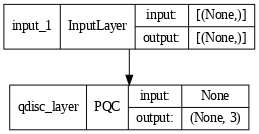

In [ ]:
# Discriminator model
C_weight = 0.5

@tf.function
def disc_loss(y_true, y_pred):
    D_true = (y_true[:, 2] + 1)/2
    D_pred = (y_pred[:, 2] + 1)/2

    D_loss = -1*(tf.math.log(D_pred + 1e-10)*D_true + tf.math.log(1 - D_pred + 1e-10)*(D_true - 1)*(-1))
    D_loss = tf.reduce_mean(D_loss, axis=0)

    C_true = (y_true[:, :2] + 1)/2
    C_pred = (y_pred[:, :2] + 1)/2

    D_true_size = tf.cast(tf.size(tf.where(D_true == 1), out_type=tf.int32), dtype=tf.float32) + 1e-10

    C_loss = tf.math.reduce_sum(tf.keras.losses.CategoricalCrossentropy(reduction='none')(C_true, C_pred) * D_true)/D_true_size

    return (1-C_weight)*D_loss + C_weight*C_loss

@tf.function
def custom_accuracy(y_true, y_pred):
    D_true = (y_true[:, 2] + 1)/2

    C_real_true = (y_true[:, :2] + 1)/2
    C_real_pred = (y_pred[:, :2] + 1)/2

    C_real_true = tf.math.argmax(C_real_true, axis=1)
    C_real_pred = tf.math.argmax(C_real_pred, axis=1)

    same = tf.cast(C_real_true == C_real_pred, tf.float32)*D_true

    D_true_size = tf.cast(tf.size(tf.where(D_true == 1), out_type=tf.int32), dtype=tf.float32) + 1e-10

    return tf.math.reduce_sum(same)/D_true_size

def discriminator_model(weights_disc):
    disc_readout_operators = [cirq.Z(qgan_qubits[-(num_class+1) + q]) for q in range(num_class+1)]

    data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

    qdisc_layer = tfq.layers.PQC(discriminator(qgan_qubits[:int((len(qgan_qubits)-(num_class+1))/2)],
                  qgan_qubits[len(qgan_qubits)-(num_class+1):], weights_disc, layer=disc_layer),
                  disc_readout_operators, name='qdisc_layer')(data_input)

    qdisc_model = tf.keras.Model(inputs=[data_input], outputs=[qdisc_layer])

    # Compile the model
    qdisc_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss=disc_loss,
                   metrics=[custom_accuracy]
                    )

    return qdisc_model

qdisc_model = discriminator_model(symbols_disc)

# Show the keras plot of the model
tf.keras.utils.plot_model(qdisc_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)

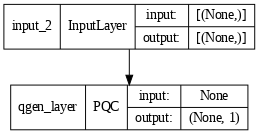

In [ ]:
# Generator loss
def gen_loss(y_true, y_pred):
    y_pred = (y_pred + 1)/2
    return tf.reduce_mean((-1)*tf.math.log(y_pred), axis=0)


# Generator model
def generator_model(symbols_gen, weights_disc):
    gen_readout_operators = cirq.Z(qgan_qubits[-1])

    data_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

    qgen_layer = tfq.layers.PQC(create_gen_disc_circuit(symbols_gen, weights_disc,
                                  qgan_qubits, num_features, num_class, gen_layer=gen_layer, disc_layer=disc_layer),
                                  gen_readout_operators, name='qgen_layer')(data_input)

    qgen_model = tf.keras.Model(inputs=[data_input], outputs=[qgen_layer])

    # Compile the model
    qgen_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                      loss=gen_loss)

    return qgen_model

qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

# Show the keras plot of the model
tf.keras.utils.plot_model(qgen_model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)

In [ ]:
# generate random data from the dataset
def generate_identity(X):
    """Generate identity quantum data."""
    quantum_data = []
    # iterate through data samples
    for sample in X:
        circuit = cirq.Circuit()

        quantum_data.append(circuit)

    return quantum_data

identity_data = tfq.convert_to_tensor(generate_identity(x_train))
identity_label = np.zeros((len(identity_data),))

print(len(identity_data), identity_label.shape)

100 (100,)


In [ ]:
print(generate_identity(x_train)[0])

In [ ]:
# fake data generator
def generate_fake_data(X, qubits, symbols, layer=1):
    """Generate fake quantum data."""
    quantum_data = []
    # iterate through data samples
    for sample in X:
        # the argument X (samples) is only used to count how many fake samples
        # to be generated, it is not used for any other things
        circuit = generator(qubits[:2*len(sample)], symbols, layer=layer)

        quantum_data.append(circuit)

    return quantum_data

# labeling fake data as -1
fake_data = tfq.convert_to_tensor(generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
y_true_fake = np.zeros((len(fake_data), num_class+1))
y_true_fake[:, 2] += (-1)

y_true_fake.shape

(100, 3)

In [ ]:
print(tfq.from_tensor(fake_data)[0])

(0, 0): ───Y^0.247─────X^0.443───Y^-0.717───Z^-0.88─────────────────────────────────@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^-0.189───Y^-0.828───Z^0.829────────────────────────────────────@───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^-0.255───Y^-0.585───Z^0.716────────────────────────────────────@─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────X^0.094───Y^(-7/15)───Z^-0.092────

In [ ]:
# training the model
# Initiate both models
qdisc_model = discriminator_model(symbols_disc)
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

In [ ]:
def checkpoints(cycle):
    gen_model_cp = tf.keras.callbacks.ModelCheckpoint(
        filepath='./model_save/cp_generator_' + str(cycle) + '.h5',
        save_weights_only=True,
        monitor='loss',
        mode='min',
        save_best_only=True)

    disc_model_cp = tf.keras.callbacks.ModelCheckpoint(
        filepath='./model_save/cp_disc_' + str(cycle) + '.h5',
        save_weights_only=True,
        monitor='custom_accuracy',
        mode='max',
        save_best_only=True)

    return gen_model_cp, disc_model_cp

In [ ]:

def train_qgen(epochs, batch, verbose):
    # Fit the Generator Model
    history = qgen_model.fit(x=identity_data,
                            y=identity_label,
                            batch_size=batch,
                            epochs=epochs,
                            verbose=verbose,
                            callbacks=[gen_model_cp])

    return history


def train_qdisc(epochs, batch, verbose):
    # Fit the Discriminator Model
    history = qdisc_model.fit(x=gen_data_train,
                            y=y_gen_train,
                            batch_size=batch,
                            epochs=epochs,
                            verbose=verbose,
                            callbacks=[disc_model_cp],
                            validation_data=(gen_data_test, y_gen_test)
                            )
    return history

Now we have to train our discriminator and generator one at a time while freezing weights, after our generator is trained good enough we have to increase $C_{weight}$ to give our classification task more priority.

In [ ]:
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]

# re-declare the generator model using the discriminator's weights
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

In [ ]:
gen_model_cp, disc_model_cp = checkpoints(cycle=1)

In [ ]:
# 1000- epochs with batch size 100
H = train_qgen(1000, 100, 1)

Epoch 1/1000
1/1 [==============================] - 12s 12s/step - loss: 0.5391
Epoch 2/1000
1/1 [==============================] - 8s 8s/step - loss: 0.5357
Epoch 3/1000
1/1 [==============================] - 5s 5s/step - loss: 0.5323
Epoch 4/1000
1/1 [==============================] - 5s 5s/step - loss: 0.5289
Epoch 5/1000
1/1 [==============================] - 4s 4s/step - loss: 0.5256
Epoch 6/1000
1/1 [==============================] - 3s 3s/step - loss: 0.5223
Epoch 7/1000
1/1 [==============================] - 2s 2s/step - loss: 0.5191
Epoch 8/1000
1/1 [==============================] - 2s 2s/step - loss: 0.5159
Epoch 9/1000
1/1 [==============================] - 2s 2s/step - loss: 0.5128
Epoch 10/1000
1/1 [==============================] - 3s 3s/step - loss: 0.5097
Epoch 11/1000
1/1 [==============================] - 4s 4s/step - loss: 0.5068
Epoch 12/1000
1/1 [==============================] - 4s 4s/step - loss: 0.5038
Epoch 13/1000
1/1 [==============================] - 3s 3s/

In [ ]:
# combine Real + Fake Data

gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)

print(y_gen_train.shape, y_gen_test.shape)

(200, 3) (200, 3)


We'll use both the real and generated data to train the discriminator to classify, now that out generator is trained we can create fake data as good as real data. and then we train our discriminator in such a way that if it detects real as real(true positive) we reward it, and if false positive then we penalize it.

In [ ]:
# Fit the Discriminator Model
H = train_qdisc(250, 64, 1)

Epoch 1/250
4/4 [==============================] - 6s 1s/step - loss: 0.7274 - custom_accuracy: 0.4545 - val_loss: 0.5946 - val_custom_accuracy: 0.1441
Epoch 2/250
4/4 [==============================] - 7s 2s/step - loss: 0.7218 - custom_accuracy: 0.3445 - val_loss: 0.5922 - val_custom_accuracy: 0.1441
Epoch 3/250
4/4 [==============================] - 6s 1s/step - loss: 0.7185 - custom_accuracy: 0.4061 - val_loss: 0.5894 - val_custom_accuracy: 0.1441
Epoch 4/250
4/4 [==============================] - 5s 1s/step - loss: 0.7130 - custom_accuracy: 0.3468 - val_loss: 0.5864 - val_custom_accuracy: 0.1441
Epoch 5/250
4/4 [==============================] - 5s 1s/step - loss: 0.7093 - custom_accuracy: 0.3895 - val_loss: 0.5834 - val_custom_accuracy: 0.1441
Epoch 6/250
4/4 [==============================] - 7s 2s/step - loss: 0.7061 - custom_accuracy: 0.3604 - val_loss: 0.5807 - val_custom_accuracy: 0.1402
Epoch 7/250
4/4 [==============================] - 5s 1s/step - loss: 0.6993 - custom_ac

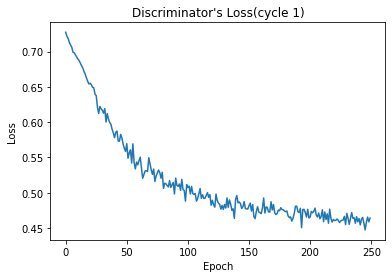

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Discriminator's Loss(cycle 1)")
plt.show()

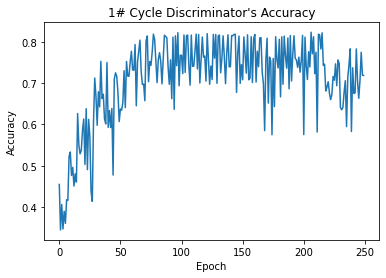

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Discriminator's Accuracy(cycle 1)")
plt.show()

The fluctuation is high because the model had to prioritize both the tasks at once

In [ ]:
custom_accuracy(np.array(y_gen_test, dtype=np.float32), qdisc_model.predict(gen_data_test))

<tf.Tensor: shape=(), dtype=float32, numpy=0.71>

Let's train the model for the 2nd cycle where the generator and discriminator should get more better.


In [ ]:
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
# saving model
gen_model_cp, disc_model_cp = checkpoints(cycle=2)

In [ ]:
# Fit the Generator Model
H = train_qgen(1000, 100, 1)

Epoch 1/1000
1/1 [==============================] - 5s 5s/step - loss: 0.3810
Epoch 2/1000
1/1 [==============================] - 3s 3s/step - loss: 0.3806
Epoch 3/1000
1/1 [==============================] - 3s 3s/step - loss: 0.3803
Epoch 4/1000
1/1 [==============================] - 4s 4s/step - loss: 0.3799
Epoch 5/1000
1/1 [==============================] - 8s 8s/step - loss: 0.3796
Epoch 6/1000
1/1 [==============================] - 7s 7s/step - loss: 0.3793
Epoch 7/1000
1/1 [==============================] - 5s 5s/step - loss: 0.3790
Epoch 8/1000
1/1 [==============================] - 5s 5s/step - loss: 0.3787
Epoch 9/1000
1/1 [==============================] - 6s 6s/step - loss: 0.3784
Epoch 10/1000
1/1 [==============================] - 5s 5s/step - loss: 0.3781
Epoch 11/1000
1/1 [==============================] - 4s 4s/step - loss: 0.3778
Epoch 12/1000
1/1 [==============================] - 4s 4s/step - loss: 0.3775
Epoch 13/1000
1/1 [==============================] - 2s 2s/st

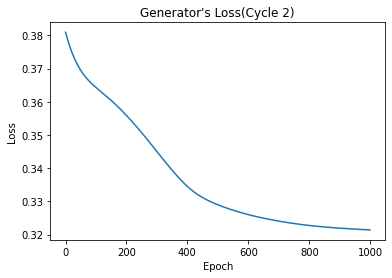

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Generator's Loss(Cycle 2)")
plt.show()

In [ ]:
# combine Real + Fake Data

gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)

print(y_gen_train.shape, y_gen_test.shape)

(200, 3) (200, 3)


Our generator got pretty good as creating new samples of data, we also have to train our discriminator.

In [ ]:
# Fit the Discriminator Model
H = train_qdisc(300, 64, 1)

Epoch 1/300
4/4 [==============================] - 6s 1s/step - loss: 0.4681 - custom_accuracy: 0.7712 - val_loss: 0.4482 - val_custom_accuracy: 0.3442
Epoch 2/300
4/4 [==============================] - 7s 2s/step - loss: 0.4648 - custom_accuracy: 0.7923 - val_loss: 0.4465 - val_custom_accuracy: 0.3442
Epoch 3/300
4/4 [==============================] - 7s 2s/step - loss: 0.4726 - custom_accuracy: 0.7917 - val_loss: 0.4449 - val_custom_accuracy: 0.3442
Epoch 4/300
4/4 [==============================] - 4s 1s/step - loss: 0.4689 - custom_accuracy: 0.7396 - val_loss: 0.4442 - val_custom_accuracy: 0.3442
Epoch 5/300
4/4 [==============================] - 4s 1s/step - loss: 0.4662 - custom_accuracy: 0.7509 - val_loss: 0.4442 - val_custom_accuracy: 0.3364
Epoch 6/300
4/4 [==============================] - 8s 2s/step - loss: 0.4576 - custom_accuracy: 0.6988 - val_loss: 0.4455 - val_custom_accuracy: 0.2956
Epoch 7/300
4/4 [==============================] - 8s 2s/step - loss: 0.4553 - custom_ac

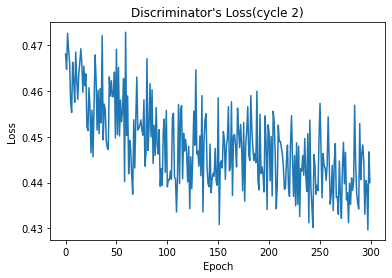

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Discriminator's Loss(cycle 2)")
plt.show()

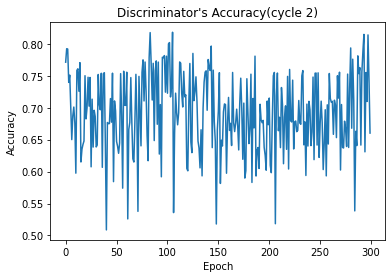

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Discriminator's Accuracy(cycle 2)")
plt.show()

The Discriminator and generator are really good now but there is a lot of fluctuation due to us prioritizing both tasks, we have to increase $C_{weight}$ for giving more priority to classifying


lets change $C_{weight}$ from $0.5 → 0.75$

In [ ]:
# 3rd Cycle
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
gen_model_cp, disc_model_cp = checkpoints(cycle=3)

We have significantly reduced the epochs to 500 for the generator as it is not so important.

In [ ]:
# Generator training
H = train_qgen(500, 100, 1)

Epoch 1/500
1/1 [==============================] - 3s 3s/step - loss: 0.5730
Epoch 2/500
1/1 [==============================] - 4s 4s/step - loss: 0.5654
Epoch 3/500
1/1 [==============================] - 4s 4s/step - loss: 0.5580
Epoch 4/500
1/1 [==============================] - 4s 4s/step - loss: 0.5506
Epoch 5/500
1/1 [==============================] - 2s 2s/step - loss: 0.5434
Epoch 6/500
1/1 [==============================] - 2s 2s/step - loss: 0.5364
Epoch 7/500
1/1 [==============================] - 2s 2s/step - loss: 0.5295
Epoch 8/500
1/1 [==============================] - 2s 2s/step - loss: 0.5228
Epoch 9/500
1/1 [==============================] - 4s 4s/step - loss: 0.5163
Epoch 10/500
1/1 [==============================] - 4s 4s/step - loss: 0.5100
Epoch 11/500
1/1 [==============================] - 3s 3s/step - loss: 0.5038
Epoch 12/500
1/1 [==============================] - 2s 2s/step - loss: 0.4978
Epoch 13/500
1/1 [==============================] - 2s 2s/step - loss: 0.

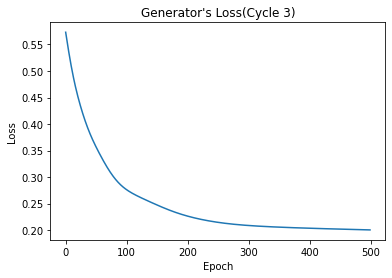

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Generator's Loss(Cycle 3)")
plt.show()

In [ ]:
gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)

print(y_gen_train.shape, y_gen_test.shape)

(200, 3) (200, 3)


In [ ]:
# Change the C_weight
C_weight = 0.75

In [ ]:
# Fit the Discriminator Model
H = train_qdisc(300, 64, 1)

Epoch 1/300
4/4 [==============================] - 5s 1s/step - loss: 0.4452 - custom_accuracy: 0.8288 - val_loss: 0.4414 - val_custom_accuracy: 0.2708
Epoch 2/300
4/4 [==============================] - 6s 2s/step - loss: 0.4477 - custom_accuracy: 0.6339 - val_loss: 0.4424 - val_custom_accuracy: 0.2708
Epoch 3/300
4/4 [==============================] - 8s 2s/step - loss: 0.4397 - custom_accuracy: 0.7113 - val_loss: 0.4420 - val_custom_accuracy: 0.2708
Epoch 4/300
4/4 [==============================] - 6s 2s/step - loss: 0.4547 - custom_accuracy: 0.7835 - val_loss: 0.4413 - val_custom_accuracy: 0.2708
Epoch 5/300
4/4 [==============================] - 8s 2s/step - loss: 0.4618 - custom_accuracy: 0.6032 - val_loss: 0.4408 - val_custom_accuracy: 0.2708
Epoch 6/300
4/4 [==============================] - 8s 2s/step - loss: 0.4634 - custom_accuracy: 0.6784 - val_loss: 0.4393 - val_custom_accuracy: 0.2708
Epoch 7/300
4/4 [==============================] - 5s 1s/step - loss: 0.4429 - custom_ac

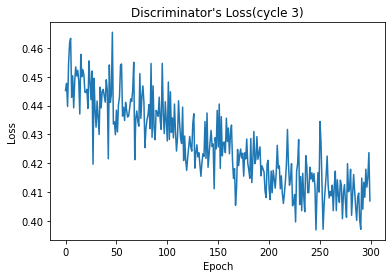

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Discriminator's Loss(cycle 3)")
plt.show()

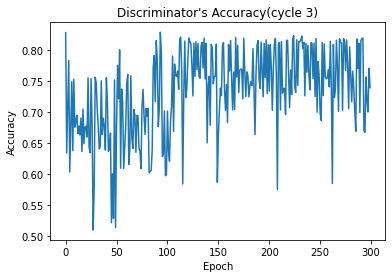

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Discriminator's Accuracy(cycle 3)")
plt.show()

In [ ]:
# Forth cycle
best_qdisc_weights = qdisc_model.get_weights()[0]
best_qgen_weights = qgen_model.get_weights()[0]
qgen_model = generator_model(symbols_gen, qdisc_model.get_weights()[0])

qgen_model.get_layer('qgen_layer').set_weights([best_qgen_weights])
qdisc_model.get_layer('qdisc_layer').set_weights([best_qdisc_weights])

In [ ]:
gen_model_cp, disc_model_cp = checkpoints(cycle=4)

In [ ]:
# Fit the Generator Model
H = train_qgen(150, 100, 1)

Epoch 1/150
1/1 [==============================] - 5s 5s/step - loss: 0.5726
Epoch 2/150
1/1 [==============================] - 4s 4s/step - loss: 0.5669
Epoch 3/150
1/1 [==============================] - 4s 4s/step - loss: 0.5612
Epoch 4/150
1/1 [==============================] - 2s 2s/step - loss: 0.5556
Epoch 5/150
1/1 [==============================] - 2s 2s/step - loss: 0.5501
Epoch 6/150
1/1 [==============================] - 2s 2s/step - loss: 0.5447
Epoch 7/150
1/1 [==============================] - 2s 2s/step - loss: 0.5394
Epoch 8/150
1/1 [==============================] - 4s 4s/step - loss: 0.5341
Epoch 9/150
1/1 [==============================] - 4s 4s/step - loss: 0.5290
Epoch 10/150
1/1 [==============================] - 4s 4s/step - loss: 0.5241
Epoch 11/150
1/1 [==============================] - 2s 2s/step - loss: 0.5192
Epoch 12/150
1/1 [==============================] - 2s 2s/step - loss: 0.5145
Epoch 13/150
1/1 [==============================] - 2s 2s/step - loss: 0.

lets further increase $C_{weight}$ from $0.75  → 0.95$

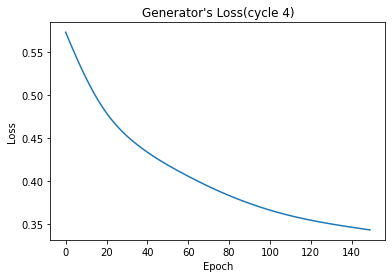

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Generator's Loss(cycle 4)")
plt.show()

In [ ]:
# Combine Real + Fake Data

gen_data_train = tfq.convert_to_tensor(generate_data(x_train, qgan_qubits) + generate_fake_data(x_train, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))
gen_data_test = tfq.convert_to_tensor(generate_data(x_test, qgan_qubits) + generate_fake_data(x_test, qgan_qubits, qgen_model.get_weights()[0], layer=gen_layer))

y_gen_train = np.concatenate((y_train, y_true_fake), axis = 0)
y_gen_test = np.concatenate((y_test, y_true_fake), axis = 0)

print(y_gen_train.shape, y_gen_test.shape)

(200, 3) (200, 3)


In [ ]:
# Change the C_weight
C_weight = 0.95

In [ ]:
# Fit the Discriminator Model
H = train_qdisc(250, 64, 1)

Epoch 1/250
4/4 [==============================] - 6s 2s/step - loss: 0.4112 - custom_accuracy: 0.7605 - val_loss: 0.3968 - val_custom_accuracy: 0.3442
Epoch 2/250
4/4 [==============================] - 8s 2s/step - loss: 0.4115 - custom_accuracy: 0.8156 - val_loss: 0.3962 - val_custom_accuracy: 0.3442
Epoch 3/250
4/4 [==============================] - 4s 1s/step - loss: 0.4081 - custom_accuracy: 0.8110 - val_loss: 0.3960 - val_custom_accuracy: 0.3442
Epoch 4/250
4/4 [==============================] - 4s 1s/step - loss: 0.4049 - custom_accuracy: 0.7759 - val_loss: 0.3956 - val_custom_accuracy: 0.3442
Epoch 5/250
4/4 [==============================] - 7s 2s/step - loss: 0.4014 - custom_accuracy: 0.7759 - val_loss: 0.3948 - val_custom_accuracy: 0.3442
Epoch 6/250
4/4 [==============================] - 6s 2s/step - loss: 0.4047 - custom_accuracy: 0.8020 - val_loss: 0.3936 - val_custom_accuracy: 0.3442
Epoch 7/250
4/4 [==============================] - 4s 1s/step - loss: 0.4044 - custom_ac

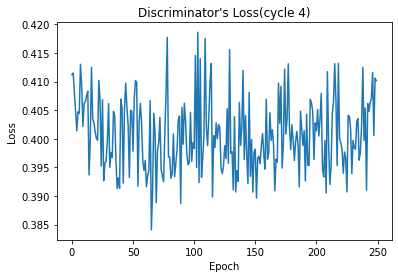

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Discriminator's Loss(cycle 4)")
plt.show()

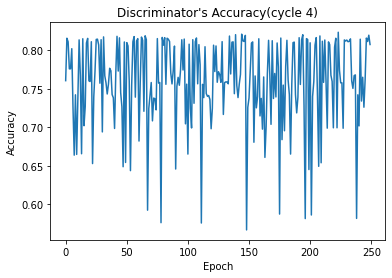

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Discriminator's Accuracy(cycle 4)")
plt.show()

In [ ]:
custom_accuracy(np.array(y_gen_test, dtype=np.float32), qdisc_model.predict(gen_data_test))

<tf.Tensor: shape=(), dtype=float32, numpy=0.71>

The 5th is the last cycle, where we give highest preference to the classification task

from our loss function
$$
L = (1-C_{weight})L_{D} + C_{weight}L_{C}
$$

since $C_{weight}$ is $1$ $L_D$ is not required at all adn will no longer matter.

So now, we just train our discriminator until it becomes a very good classifier.

In [ ]:
# fit the model
history = qdisc_model.fit(x=train_quantum_data,
                          y=y_train,
                          batch_size=32,
                          epochs=1000,
                          verbose=1,
                          callbacks=[disc_model_cp],
                          validation_data=(test_quantum_data, y_test)
                          )

Epoch 1/1000
4/4 [==============================] - 1s 395ms/step - loss: 0.4564 - custom_accuracy: 0.7031 - val_loss: 0.4698 - val_custom_accuracy: 0.7734
Epoch 2/1000
4/4 [==============================] - 1s 371ms/step - loss: 0.4420 - custom_accuracy: 0.7031 - val_loss: 0.4515 - val_custom_accuracy: 0.7734
Epoch 3/1000
4/4 [==============================] - 1s 282ms/step - loss: 0.4221 - custom_accuracy: 0.8125 - val_loss: 0.4324 - val_custom_accuracy: 0.7734
Epoch 4/1000
4/4 [==============================] - 1s 231ms/step - loss: 0.4023 - custom_accuracy: 0.7578 - val_loss: 0.4144 - val_custom_accuracy: 0.7734
Epoch 5/1000
4/4 [==============================] - 1s 234ms/step - loss: 0.3835 - custom_accuracy: 0.8125 - val_loss: 0.3983 - val_custom_accuracy: 0.7734
Epoch 6/1000
4/4 [==============================] - 1s 230ms/step - loss: 0.3673 - custom_accuracy: 0.7031 - val_loss: 0.3842 - val_custom_accuracy: 0.7734
Epoch 7/1000
4/4 [==============================] - 1s 245ms/ste

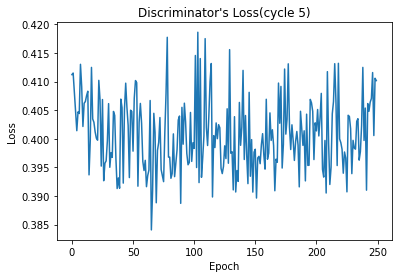

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Discriminator's Loss(cycle 5)")
plt.show()

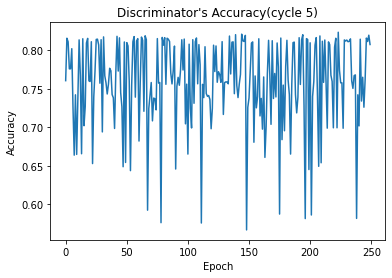

In [ ]:
plt.plot(H.history['custom_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Discriminator's Accuracy(cycle 5)")
plt.show()

In [ ]:
qdisc_model.save_weights('./model_save/disc_final.h5')
qgen_model.save_weights('./model_save/gen_final.h5')

In [ ]:
qdisc_model.load_weights('./model_save/disc_final.h5')

In [ ]:
from sklearn.metrics import roc_auc_score

print("Training Accuracy:", custom_accuracy(np.array(y_train, dtype=np.float32), qdisc_model.predict(train_quantum_data)).numpy())
print("Testing Accuracy", custom_accuracy(np.array(y_test, dtype=np.float32), qdisc_model.predict(test_quantum_data)).numpy())

print("Training AUC:", roc_auc_score(np.argmax(((y_train+1)/2)[:, :2], axis=1), (((qdisc_model.predict(train_quantum_data)+1)/2)[:, :2])[:, 1]))
print("Testing AUC:", roc_auc_score(np.argmax(((y_test+1)/2)[:, :2], axis=1), (((qdisc_model.predict(test_quantum_data)+1)/2)[:, :2])[:, 1]))

Training Accuracy: 0.76
Testing Accuracy 0.71
Training AUC: 0.8248
Testing AUC: 0.788



### Result





**Generator statistics**


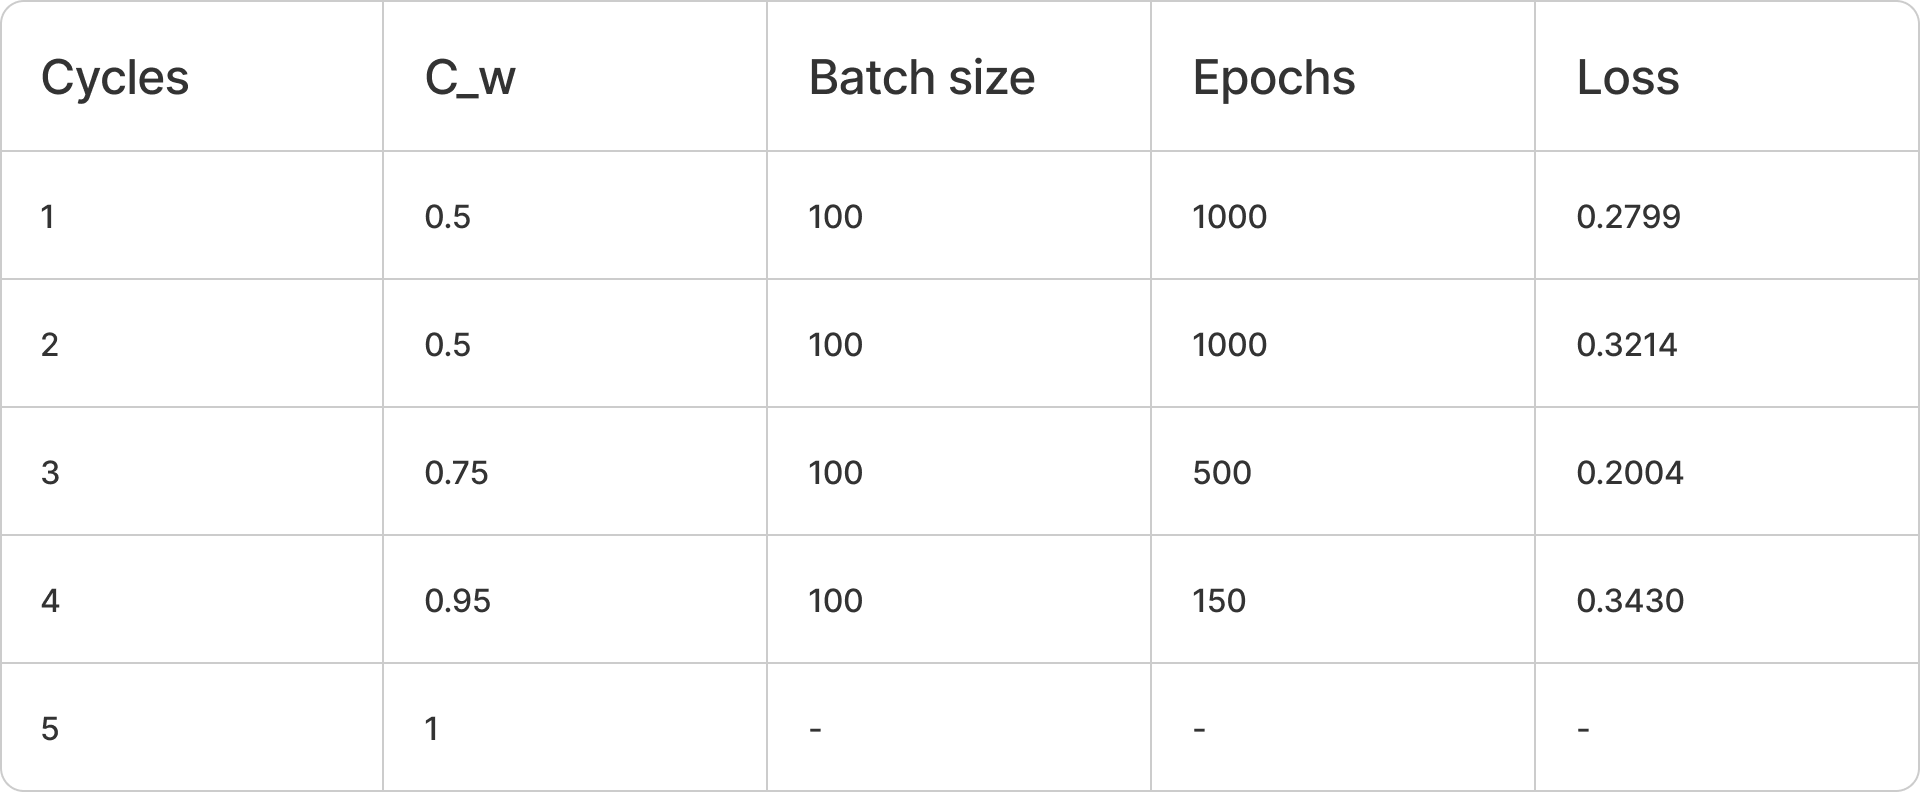




**Discriminator's statistics**

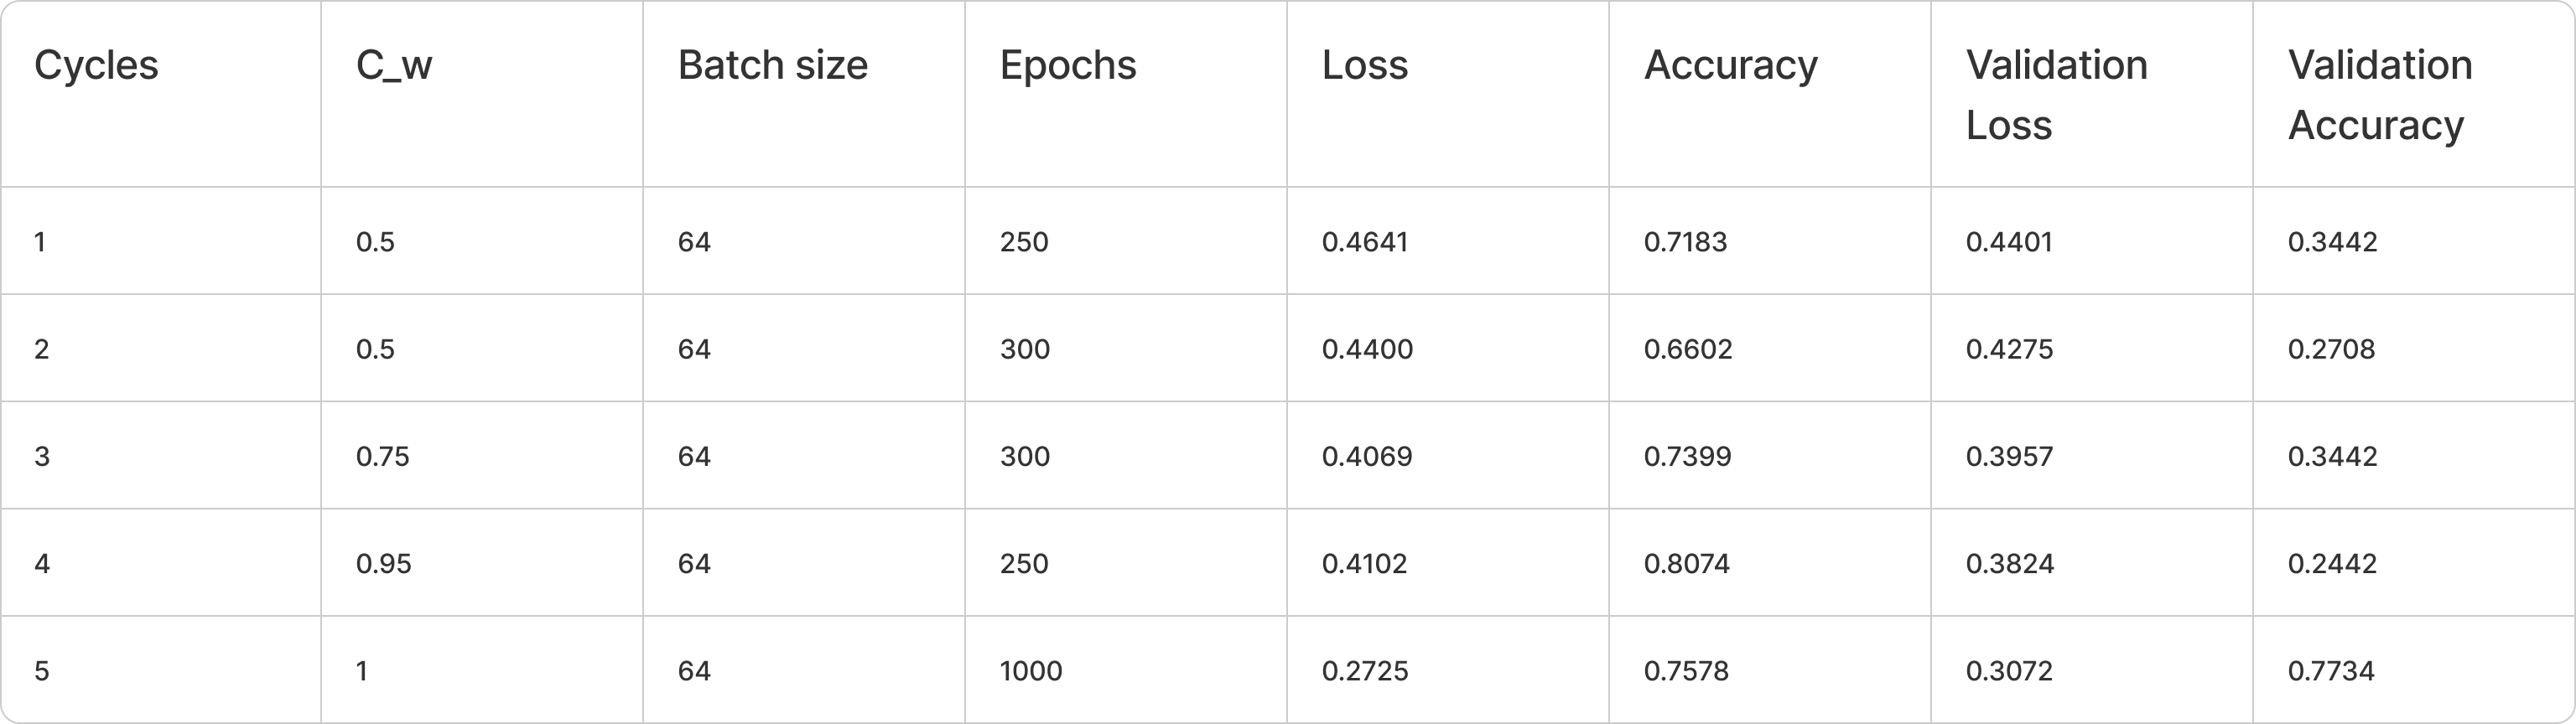

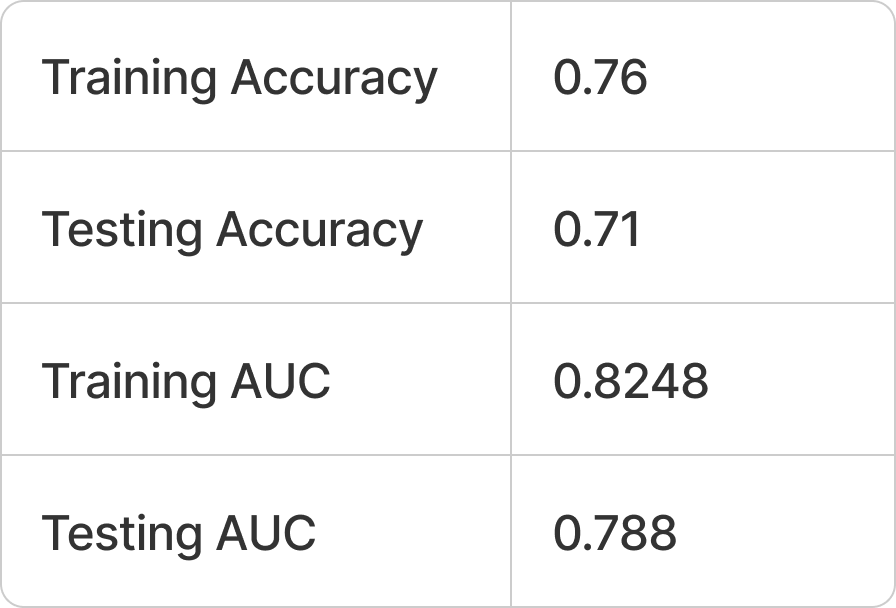

The model gives a reasonably good performance with testing Accuracy of 71% and testing AUC of 78.8%, there is a gap in testing and training performance which is likely that the model is overfitting but is expected given the small size of the dataset.

You can see that the loss was increasing in the 4th cycle of the generator that is because we trained it for less number of epochs and we're not much concered at that point as $C_{weight}$ is nearly 1.

There is a sudden increase in accuracy at the last cycle in the discriminator because that is when we actually train it for classifying.

GAN's are typically generative models, but here we used to create fake data and then classified using our trained discriminator which solved a classification task. This was personally very interesting.

References
- [Quantum semi-supervised generative adversarial network for enhanced
data classification](https://arxiv.org/pdf/2010.13727.pdf)
- [Entangling Quantum Generative Adversarial Networks](https://arxiv.org/pdf/2105.00080.pdf)